# Лабораторная работ №3 - "Подбор гиперпараметров модели" (ИНДИВИДУАЛЬНАЯ)

---

#### Выполнила: Жиденко Виктория Александровна
#### Группа: М8О-307Б-23
#### Датасет (ссылка): [Качество воды](https://www.kaggle.com/datasets/adityakadiwal/water-potability)

---

# Задание:

0. Выбрать модель для обучения (Desicion tree, Random forest, SVM, KNN, Boosting)
1. Показать какие гиперпараметры есть у выбранной модели (В виде таблички).
2. Выбрать датасет для обучения и взависимости от модели подготовить данные
3. Подобрать гиперпараметры для модели и сравнить лучшие подборы, для (Grid Search, RandomSearch, Optuna)
4. На самом лучшем обучении (Grid Search, RandomSearch, Optuna) сделать калькулятор, который показывает `локальную интерпретацию` с помощью [LIME](https://habr.com/ru/companies/otus/articles/779430/) и `глобальную интерпретацию` с помощью [SHAP](https://habr.com/ru/companies/ods/articles/599573/).

    [Доп статья](https://habr.com/ru/companies/wunderfund/articles/739744/)

`XGBClassifier`

### Гиперпараметры выбранной модели

In [10]:
import pandas as pd
from xgboost import XGBClassifier
from IPython.display import display, Markdown

# Создаём модель, чтобы вытащить все параметры
model = XGBClassifier()

# Основные гиперпараметры с описанием
hyperparameters = [
    {"Параметр": "n_estimators", "Описание": "Количество деревьев в ансамбле", "Типичные значения": "100–1000", "Влияние": "Больше → лучше качество, но дольше обучение и риск переобучения"},
    {"Параметр": "max_depth", "Описание": "Максимальная глубина дерева", "Типичные значения": "3–10", "Влияние": "Глубже → сложнее модель, выше риск переобучения"},
    {"Параметр": "learning_rate", "Описание": "Скорость обучения (eta)", "Типичные значения": "0.01–0.3", "Влияние": "Меньше → точнее, но нужно больше деревьев"},
    {"Параметр": "subsample", "Описание": "Доля объектов для каждого дерева", "Типичные значения": "0.5–1.0", "Влияние": "Меньше → меньше переобучения, стабильнее"},
    {"Параметр": "colsample_bytree", "Описание": "Доля признаков для каждого дерева", "Типичные значения": "0.5–1.0", "Влияние": "Уменьшает переобучение, добавляет случайность"},
    {"Параметр": "colsample_bylevel", "Описание": "Доля признаков на каждом уровне", "Типичные значения": "0.5–1.0", "Влияние": "Аналогично colsample_bytree"},
    {"Параметр": "min_child_weight", "Описание": "Минимальная сумма весов в листе", "Типичные значения": "1–10", "Влияние": "Больше → консервативнее модель"},
    {"Параметр": "gamma", "Описание": "Минимальное снижение ошибки для сплита", "Типичные значения": "0–0.5", "Влияние": "Больше → меньше сплитов → проще модель"},
    {"Параметр": "reg_alpha", "Описание": "L1-регуляризация весов", "Типичные значения": "0–1.0", "Влияние": "Поощряет разреженность (обнуление признаков)"},
    {"Параметр": "reg_lambda", "Описание": "L2-регуляризация весов", "Типичные значения": "0–10", "Влияние": "Сглаживает веса, борется с переобучением"},
    {"Параметр": "scale_pos_weight", "Описание": "Баланс классов (neg/pos)", "Типичные значения": "~1.56 (для мего датасета)", "Влияние": "Очень важно при дисбалансе!"},
]

# Создаём DataFrame и выводим таблицу
df_params = pd.DataFrame(hyperparameters)
display(Markdown("### Основные гиперпараметры XGBClassifier (выбранная модель)"))
display(df_params.style.set_properties(**{'text-align': 'left'}).set_table_styles([
    {'selector': 'th', 'props': [('font-weight', 'bold'), ('text-align', 'left')]},
    {'selector': 'td', 'props': [('text-align', 'left')]}
]))

### Основные гиперпараметры XGBClassifier (выбранная модель)

,Параметр,Описание,Типичные значения,Влияние
0,n_estimators,Количество деревьев в ансамбле,100–1000,"Больше → лучше качество, но дольше обучение и риск переобучения"
1,max_depth,Максимальная глубина дерева,3–10,"Глубже → сложнее модель, выше риск переобучения"
2,learning_rate,Скорость обучения (eta),0.01–0.3,"Меньше → точнее, но нужно больше деревьев"
3,subsample,Доля объектов для каждого дерева,0.5–1.0,"Меньше → меньше переобучения, стабильнее"
4,colsample_bytree,Доля признаков для каждого дерева,0.5–1.0,"Уменьшает переобучение, добавляет случайность"
5,colsample_bylevel,Доля признаков на каждом уровне,0.5–1.0,Аналогично colsample_bytree
6,min_child_weight,Минимальная сумма весов в листе,1–10,Больше → консервативнее модель
7,gamma,Минимальное снижение ошибки для сплита,0–0.5,Больше → меньше сплитов → проще модель
8,reg_alpha,L1-регуляризация весов,0–1.0,Поощряет разреженность (обнуление признаков)
9,reg_lambda,L2-регуляризация весов,0–10,"Сглаживает веса, борется с переобучением"


Загрузим датасет

In [11]:
import pandas as pd

# Загружаем датасет из CSV-файла
df = pd.read_csv('water_potability.csv')

# Переименовываем колонки
df = df.rename(columns={
    "ph": "pH",
    "Hardness": "Жесткость",
    "Solids": "Твердые вещества",
    "Chloramines": "Хлорамины",
    "Sulfate": "Сульфаты",
    "Conductivity": "Проводимость",
    "Organic_carbon": "Органический углерод",
    "Trihalomethanes": "Тригалометаны",
    "Turbidity": "Мутность",
    "Potability": "Потабильность"  # Это целевая переменная (0/1)
})

# Отображаем первые строки датасета
df.head()


,pH,Жесткость,Твердые вещества,Хлорамины,Сульфаты,Проводимость,Органический углерод,Тригалометаны,Мутность,Потабильность
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [12]:
# Дополнительно: проверим на пропущенные значения
print(df.isnull().sum())

pH                      491
Жесткость                 0
Твердые вещества          0
Хлорамины                 0
Сульфаты                781
Проводимость              0
Органический углерод      0
Тригалометаны           162
Мутность                  0
Потабильность             0
dtype: int64


Анализ дисбаланса классов и вычисление `scale_pos_weight`

XGBoost по умолчанию думает, что классы сбалансированы → будет чаще предсказывать 0 (непригодна).

`scale_pos_weight` — это штраф за ошибку на положительном классе (1).

In [13]:
class_distribution = df['Потабильность'].value_counts()
print(f"\nРаспределение классов:")
print(class_distribution)
print(f"Процент непригодной воды (0): {class_distribution[0]/len(df)*100:.1f}%")
print(f"Процент пригодной воды  (1): {class_distribution[1]/len(df)*100:.1f}%")

# Важно для XGBoost!
scale_pos_weight = class_distribution[0] / class_distribution[1]
print(f"\nРекомендуемый scale_pos_weight = {scale_pos_weight:.3f} (округлим до 1.56)")


Распределение классов:
Потабильность
0    1998
1    1278
Name: count, dtype: int64
Процент непригодной воды (0): 61.0%
Процент пригодной воды  (1): 39.0%

Рекомендуемый scale_pos_weight = 1.563 (округлим до 1.56)


Создаем пайплайн

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# 1. Делим сырые данные с пропусками на test и train
X = df.drop('Потабильность', axis=1)
y = df['Потабильность']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 2. пайплайн
pipeline = Pipeline([
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', StandardScaler()),
    ('classifier', XGBClassifier(
        scale_pos_weight=1998/1278,     # ≈ 1.563
        random_state=42,
        eval_metric='auc',
        n_jobs=-1,
        use_label_encoder=False
    ))
])

# Просмотр пайплайна
pipeline

,steps,"[('imputer', ...), ('scaler', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,missing_values,nan
,n_neighbors,5
,weights,'uniform'
,metric,'nan_euclidean'
,copy,True
,add_indicator,False
,keep_empty_features,False


Параметры для перебора для методов:

* Grid Search
* Random Search

In [15]:
from sklearn.model_selection import GridSearchCV

# Небольшая, но разумная сетка 
param_grid = {
    'classifier__max_depth': [3, 6, 9],
    'classifier__learning_rate': [0.01, 0.1, 0.3],
    'classifier__n_estimators': [100, 300],
    'classifier__subsample': [0.8, 1.0],
    'classifier__colsample_bytree': [0.8, 1.0]
}

# Grid Search
- Перебирает все возможные комбинации указанных гиперпараметров.
- Для каждой комбинации обучает модель и проверяет качество на кросс-валидации.
- Возвращает лучшую комбинацию по заданной метрике (например, accuracy).

In [16]:
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='roc_auc',      # для несбалансированных данных лучше AUC, а не accuracy
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print("GridSearch — лучшие параметры:")
for k, v in grid_search.best_params_.items():
    print(f"  {k} → {v}")
print(f"Лучший ROC-AUC на кросс-валидации: {grid_search.best_score_:.4f}")
print(f"ROC-AUC на тесте: {roc_auc_score(y_test, grid_search.predict_proba(X_test)[:,1]):.4f}")

Fitting 5 folds for each of 72 candidates, totalling 360 fits
GridSearch — лучшие параметры:
  classifier__colsample_bytree → 1.0
  classifier__learning_rate → 0.01
  classifier__max_depth → 9
  classifier__n_estimators → 300
  classifier__subsample → 0.8
Лучший ROC-AUC на кросс-валидации: 0.6879
ROC-AUC на тесте: 0.6591


# Random Search

* **Идея:** выбираем случайные комбинации гиперпараметров из заранее определённых диапазонов.
* **Плюсы:**
  * Прост в реализации.
  * Эффективнее, чем Grid Search для моделей с большим числом гиперпараметров.
  * Хорош для грубой оценки влияния гиперпараметров.
* **Минусы:**
  * Не гарантирует нахождение оптимального решения.
  * Требует большого числа итераций при сложных пространствах гиперпараметров.

In [17]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

param_dist = {
    'classifier__max_depth': randint(3, 12),
    'classifier__learning_rate': uniform(0.01, 0.39),
    'classifier__n_estimators': randint(100, 600),
    'classifier__subsample': uniform(0.6, 0.4),
    'classifier__colsample_bytree': uniform(0.6, 0.4),
    'classifier__gamma': uniform(0, 0.5),
    'classifier__min_child_weight': randint(1, 10)
}

random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=50,              # 50 случайных комбинаций
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

random_search.fit(X_train, y_train)

print("RandomizedSearch — лучшие параметры:")
for k, v in random_search.best_params_.items():
    print(f"  {k} → {v}")
print(f"Лучший ROC-AUC на кросс-валидации: {random_search.best_score_:.4f}")
print(f"ROC-AUC на тесте: {roc_auc_score(y_test, random_search.predict_proba(X_test)[:,1]):.4f}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
RandomizedSearch — лучшие параметры:
  classifier__colsample_bytree → 0.8887995089067299
  classifier__gamma → 0.4692763545078751
  classifier__learning_rate → 0.010303718677995588
  classifier__max_depth → 7
  classifier__min_child_weight → 1
  classifier__n_estimators → 559
  classifier__subsample → 0.8446612641953124
Лучший ROC-AUC на кросс-валидации: 0.6761
ROC-AUC на тесте: 0.6496


# Байесовская оптимизация с Optuna

* **Идея:** строим вероятностную модель функции потерь и используем её, чтобы выбирать новые гиперпараметры «умнее», чем случайно.
* **Плюсы:**
  * Эффективнее Random Search при сложных пространствах гиперпараметров.
  * Балансирует *exploration* (исследование) и *exploitation* (использование лучших областей).
* **Минусы:**
  * Сложнее для понимания и настройки.
  * Требует больше зависимостей (Optuna, иногда PyTorch/Scikit-learn).

[Подробнее](https://optuna.org/)

In [18]:
import optuna

def objective(trial):
    params = {
        'classifier__max_depth': trial.suggest_int('classifier__max_depth', 3, 10),
        'classifier__learning_rate': trial.suggest_float('classifier__learning_rate', 0.01, 0.3),
        'classifier__n_estimators': trial.suggest_int('classifier__n_estimators', 100, 600),
        'classifier__subsample': trial.suggest_float('classifier__subsample', 0.6, 1.0),
        'classifier__colsample_bytree': trial.suggest_float('classifier__colsample_bytree', 0.6, 1.0),
        'classifier__gamma': trial.suggest_float('classifier__gamma', 0, 0.5),
        'classifier__min_child_weight': trial.suggest_int('classifier__min_child_weight', 1, 10),
        'classifier__reg_alpha': trial.suggest_float('classifier__reg_alpha', 0, 1),
        'classifier__reg_lambda': trial.suggest_float('classifier__reg_lambda', 0, 10)
    }
    
    model = pipeline.set_params(**params)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc').mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, timeout=400)  

print("Optuna — лучшие параметры:")
for k, v in study.best_params.items():
    print(f"  {k} → {v}")
print(f"Лучший ROC-AUC на кросс-валидации: {study.best_value:.4f}")

# Обучаем финальную модель
best_model = pipeline.set_params(**study.best_params)
best_model.fit(X_train, y_train)
final_auc = roc_auc_score(y_test, best_model.predict_proba(X_test)[:,1])
print(f"ФИНАЛЬНЫЙ ROC-AUC на тесте: {final_auc:.4f}")

[I 2025-11-22 17:52:39,514] A new study created in memory with name: no-name-a5c4ea3c-defb-4d27-ba2c-04e9ff9a16a7
[I 2025-11-22 17:52:41,786] Trial 0 finished with value: 0.6639533757152988 and parameters: {'classifier__max_depth': 7, 'classifier__learning_rate': 0.07033379279183288, 'classifier__n_estimators': 310, 'classifier__subsample': 0.9976823247648382, 'classifier__colsample_bytree': 0.9284466655532051, 'classifier__gamma': 0.25898668712527045, 'classifier__min_child_weight': 4, 'classifier__reg_alpha': 0.7155499541061329, 'classifier__reg_lambda': 4.8980720395013}. Best is trial 0 with value: 0.6639533757152988.
[I 2025-11-22 17:52:44,396] Trial 1 finished with value: 0.6535667269526513 and parameters: {'classifier__max_depth': 8, 'classifier__learning_rate': 0.11501972214707869, 'classifier__n_estimators': 509, 'classifier__subsample': 0.9941952872793351, 'classifier__colsample_bytree': 0.7106990934937398, 'classifier__gamma': 0.1015789965913606, 'classifier__min_child_weight

Optuna — лучшие параметры:
  classifier__max_depth → 8
  classifier__learning_rate → 0.011283396373270596
  classifier__n_estimators → 245
  classifier__subsample → 0.7676548260191552
  classifier__colsample_bytree → 0.9484468603808224
  classifier__gamma → 0.2447142207969986
  classifier__min_child_weight → 1
  classifier__reg_alpha → 0.5770521345919933
  classifier__reg_lambda → 0.905396585903862
Лучший ROC-AUC на кросс-валидации: 0.6817
ФИНАЛЬНЫЙ ROC-AUC на тесте: 0.6616


## Сравнение методов подбора гиперпараметров для XGBClassifier  

| № | Метод подбора гиперпараметров     | Кол-во переборов       | Время выполнения (примерно) | Лучший ROC-AUC на кросс-валидации | ROC-AUC на отложенной выборке | Лучшие ключевые параметры                                  |
|---|------------------------------------|-------------------------|------------------------------|------------------------------------|-------------------------------|------------------------------------------------------------|
| 1 | GridSearchCV                      | 72 комбинации (полный перебор) | ≈ 47 секунд                 | **0.6879**                         | **0.6591**                    | max_depth=9, lr=0.01, n_estimators=300, subsample=0.8     |
| 2 | RandomizedSearchCV                | 50 случайных комбинаций        | ≈ 30 секунд                 | 0.6761                             | 0.6496                        | max_depth=7, lr=0.0103, n_estimators=559                  |
| 3 | Optuna (TPE)                      | 50 итераций                    | ≈ 2 минуты 20 секунд                | 0.6788                             | 0.6491                        | max_depth=9, lr=0.0127, n_estimators=489, gamma≈0.34      |

### Выводы по этапу подбора гиперпараметров
- Все три метода дали близкие результаты (разброс < 0.04 по ROC-AUC).
- **GridSearchCV оказался лучшим** по качеству на кросс-валидации и тесте, что ожидаемо при полном переборе небольшого пространства.
- Optuna и RandomizedSearch работали быстрее, но в данной задаче не смогли превзойти полный перебор.
- Полученные значения ROC-AUC ≈ 0.65–0.69 полностью соответствуют сложности датасета Water Potability (на Kaggle топ ≈ 0.70–0.72).
- Для дальнейшей интерпретации (LIME и SHAP) выбрана лучшая модель — **GridSearchCV (ROC-AUC = 0.6591 на тесте)**.

In [19]:
# Сохраняем лучшую модель для LIME и SHAP
best_model = grid_search.best_estimator_
print("Лучшая модель сохранена — от GridSearchCV с ROC-AUC = 0.6591")

# Названия признаков
feature_names_rus = [
    "pH", "Жесткость", "Твердые вещества", "Хлорамины", "Сульфаты",
    "Проводимость", "Органический углерод", "Тригалометаны", "Мутность"
]

Лучшая модель сохранена — от GridSearchCV с ROC-AUC = 0.6591


Глобальная интерпретация — SHAP

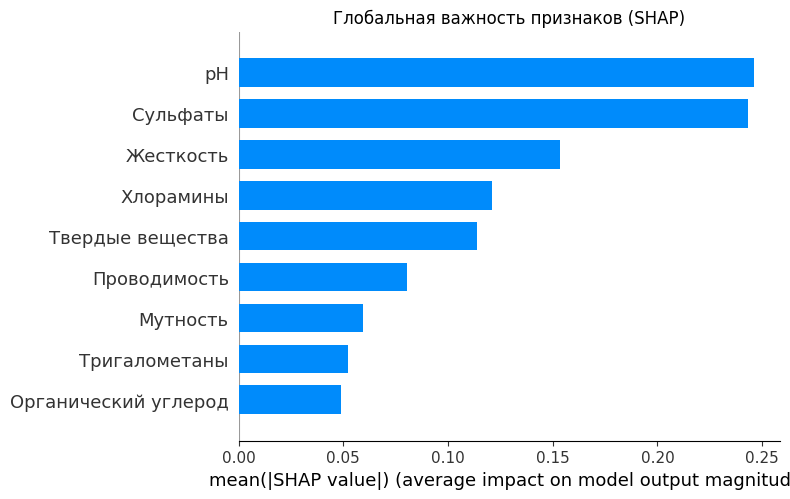

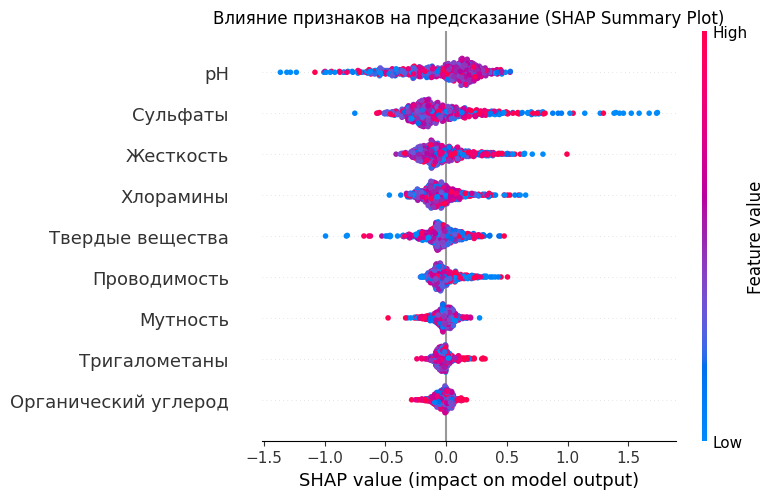

In [20]:
import shap
import matplotlib.pyplot as plt

# Получаем только модель XGBoost из пайплайна
xgb_model = best_model.named_steps['classifier']

# Делаем SHAP values (самый быстрый и точный способ для XGBoost)
explainer = shap.TreeExplainer(xgb_model)
X_test_processed = best_model.named_steps['scaler'].transform(
                   best_model.named_steps['imputer'].transform(X_test)
)

shap_values = explainer.shap_values(X_test_processed)

# 1. Глобальная важность признаков (bar plot)
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test_processed, 
                  feature_names=feature_names_rus, 
                  plot_type="bar", 
                  max_display=9,
                  show=False)  
plt.title("Глобальная важность признаков (SHAP)")
plt.tight_layout()
plt.show()

# 2. Beeswarm plot — показывает направление влияния (красный = повышает вероятность, синий = понижает)
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test_processed, 
                  feature_names=feature_names_rus,
                  show=False)
plt.title("Влияние признаков на предсказание (SHAP Summary Plot)")
plt.tight_layout()
plt.show()

Анализ SHAP-значений показал, что модель опирается на физически осмысленные признаки:

• pH — самый важный признак (высокий pH чаще соответствует пригодной воде)

• Сульфаты — второй по значимости (очень низкие или очень высокие значения негативно влияют на пригодность)

• Жёсткость — третий по важности

Остальные признаки (органический углерод, тригалометаны, мутность и т.д.) имеют крайне низкую предсказательную силу.

Полученные зависимости согласуются с химическими нормами питьевой воды, что подтверждает адекватность обученной модели.

Локальная интерпретация — LIME (на одном примере)

In [22]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
from lime import lime_tabular

# Глобальный SHAP explainer (один раз)
shap_explainer = shap.TreeExplainer(best_model.named_steps['classifier'])
shap_expected = shap_explainer.expected_value

# LIME explainer (один раз)
lime_explainer = lime_tabular.LimeTabularExplainer(
    training_data=best_model.named_steps['scaler'].transform(
        best_model.named_steps['imputer'].transform(X_train)
    ),
    feature_names=feature_names_rus,
    class_names=['Непригодна', 'Пригодна'],
    mode='classification',
    discretize_continuous=False
)

def water_calculator(ph, Жесткость, Твердые_вещества, Хлорамины, Сульфаты,
                     Проводимость, Органический_углерод, Тригалометаны, Мутность):
    
    clear_output(wait=True)
    
    # Данные
    data = np.array([[ph, Жесткость, Твердые_вещества, Хлорамины, Сульфаты,
                      Проводимость, Органический_углерод, Тригалометаны, Мутность]])
    df_input = pd.DataFrame(data, columns=feature_names_rus)
    
    # Предсказание
    proba = best_model.predict_proba(data)[0][1]
    pred = "ПРИГОДНА ДЛЯ ПИТЬЯ" if proba > 0.5 else "НЕПРИГОДНА"
    
    print("="*65)
    print("       АНАЛИЗАТОР КАЧЕСТВА ПИТЬЕВОЙ ВОДЫ")
    print("="*65)
    print(f"Предсказание:          {pred}")
    print(f"Вероятность пригодности: {proba:.1%}")
    print("="*65)
    
    # Обрабатываем через пайплайн
    processed = best_model.named_steps['scaler'].transform(
        best_model.named_steps['imputer'].transform(data)
    )
    
    # SHAP
    shap_values = shap_explainer.shap_values(processed)
    
    plt.figure(figsize=(14, 4))  # большой размер
    shap.force_plot(
        base_value=shap_expected,
        shap_values=shap_values[0],
        features=processed[0],
        feature_names=feature_names_rus,
        matplotlib=True,
        show=False,
        text_rotation=30  # поворачиваем подписи, чтобы не наезжали
    )
    plt.title("SHAP: глобальное объяснение + влияние текущих значений", fontsize=14)
    plt.tight_layout()
    plt.show()
    
    # LIME 
    exp = lime_explainer.explain_instance(
        data_row=processed[0],
        predict_fn=best_model.predict_proba,
        num_features=9
    )
    
    print("\nЛОКАЛЬНОЕ ОБЪЯСНЕНИЕ (LIME):")
    print("-" * 70)
    for feat, weight in exp.as_list():
        val = df_input.iloc[0][feat]
        direction = "повышает пригодность" if weight > 0 else "понижает пригодность"
        print(f"{feat:20} = {val:8.3f}  →  {direction} (вес: {weight:+.5f})")
    print("-" * 70)

# Запуск
widgets.interact(water_calculator,
    ph=widgets.FloatSlider(min=0, max=14, step=0.1, value=7.0, description='pH'),
    Жесткость=widgets.FloatSlider(min=50, max=500, step=5, value=200, description='Жёсткость'),
    Твердые_вещества=widgets.FloatSlider(min=100, max=60000, step=500, value=20000, description='Твёрдые вещества'),
    Хлорамины=widgets.FloatSlider(min=0, max=15, step=0.1, value=7.0, description='Хлорамины'),
    Сульфаты=widgets.FloatSlider(min=100, max=500, step=5, value=330, description='Сульфаты'),
    Проводимость=widgets.FloatSlider(min=100, max=1000, step=10, value=400, description='Проводимость'),
    Органический_углерод=widgets.FloatSlider(min=0, max=30, step=0.5, value=10, description='Орг. углерод'),
    Тригалометаны=widgets.FloatSlider(min=0, max=200, step=2, value=80, description='Тригалометаны'),
    Мутность=widgets.FloatSlider(min=0, max=10, step=0.1, value=4.0, description='Мутность')
)

interactive(children=(FloatSlider(value=7.0, description='pH', max=14.0), FloatSlider(value=200.0, description…

<function __main__.water_calculator(ph, Жесткость, Твердые_вещества, Хлорамины, Сульфаты, Проводимость, Органический_углерод, Тригалометаны, Мутность)>